### Load Libraries

In [1]:
install.packages("rstan")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘matrixStats’, ‘StanHeaders’, ‘inline’, ‘gridExtra’, ‘Rcpp’, ‘RcppParallel’, ‘loo’, ‘RcppEigen’, ‘BH’




In [2]:
library(rstan)
options(mc.cores = parallel::detectCores())

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.5, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



### Specify the stan model

In [3]:
model <- "
functions {
  // Create adstock function for use in Stan
  vector adstock(vector x, int n_timesteps, real rate) {
  vector[n_timesteps] out = x;
    for (i in 1 : n_timesteps) {
     if (i == 1) {
       out[i] = out[i] * rate ;
     } else {
       out[i] = out[i] * rate + (1-rate) * out[i-1];
     }
    }
    return (out);
  }
}

// Declare what data comes into the model
data {
  int n_timesteps;
  int n_channels;
  matrix[n_timesteps, n_channels] spend;
  vector[n_timesteps] depvar;
}

// Declare what parameters the model is estimating
parameters {
  real<lower=0> intercept;
  real<lower=0> sigma;
  vector<lower=0>[n_channels] betas;
  vector[n_channels] adstock_rates_raw;
  vector<lower=0>[n_channels] kappas; // half-saturation point. How to set?
}

// Specify how the parameters relate to each other
transformed parameters {
  vector[n_timesteps] predicted = rep_vector(0, n_timesteps);
  vector[n_channels] adstock_rates = inv_logit(adstock_rates_raw);
  matrix[n_timesteps, n_channels] rois;
  matrix[n_timesteps, n_channels] adstocked_spend;

  predicted = rep_vector(intercept, n_timesteps);
  for(i in 1:n_channels) {
    adstocked_spend[, i] = adstock(spend[, i], n_timesteps, adstock_rates[i]);
    for (j in 1:n_timesteps) {
      rois[j, i] = betas[i] * kappas[i] / (adstocked_spend[j, i] + kappas[i]);
    }
    predicted += rois[, i] .* adstocked_spend[,i];
  }

}

// Specify the priors & distributions for the parameters
model {
  intercept ~ normal(0,1);
  betas ~ normal(0,1);
  adstock_rates_raw ~ normal(0,1);
  kappas ~ normal(0,1);
  sigma ~ exponential(1);
  depvar ~ normal(predicted, sigma);
}
"

# Generate data

Here, we're going to generate data that look like marketing spend data. Crucially, we're going to use parameters that we know in advance so that we can see if the model we specified above can get to the correct answer.

In [4]:
# Create the adstock function
adstock <- function(x, rate) {
  for (i in 1:length(x)) {
     if (i == 1) {
       x[i] <- x[i] * rate
     } else {
       x[i] <- x[i] * rate + (1-rate) * x[i-1];
     }
  }
  return (x)
}


time <- 500

spend <- matrix(, ncol=2, nrow= time)

# Create two random variables representing marketing spend
spend[,1] <- abs(cumsum(rnorm(time,)))
spend[,2] <- abs(cumsum(rnorm(time,)))

# Define the "true values" for the parameters we're trying to estimate.
true_betas <- c(0.5, 1.5)
true_adstocks <- c(0.1, 0.35)
true_kappas <- c(0.4, 0.99)
true_intercept <- 3

as_spend <- matrix(, nrow=time, ncol=2)
rois <- as_spend

for (i in 1:ncol(spend)) {
  as_spend[,i] <- adstock(spend[,i], true_adstocks[i])
  rois[,i] <- true_betas[i] * true_kappas[i] / (as_spend[,i] + true_kappas[i])
}

dv <- rep(true_intercept, time)
for (i in 1:ncol(spend)) {
  dv <- dv + as_spend[,i] * rois[,i]
}

dv <- dv + rnorm(time, 0, 0.01)

### Fit Model

In [5]:
stan_data <- list(n_timesteps = time, n_channels = 2, spend = spend, depvar = dv)

m <- rstan::stan_model(model_code = model)
fit <- sampling(m, data=stan_data, chains = 2, cores = 2)

print(fit, pars=c("intercept", "betas", "kappas", "adstock_rates"))


Warning message:
“There were 1197 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
https://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


Inference for Stan model: a4a8d0012fa0148658a7ddb8cdb4e44a.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

                 mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
intercept        2.97    0.00 0.02 2.93 2.96 2.97 2.99  3.01   830    1
betas[1]         0.56    0.01 0.25 0.19 0.38 0.53 0.71  1.09   517    1
betas[2]         1.58    0.00 0.07 1.45 1.53 1.57 1.63  1.72   500    1
kappas[1]        0.39    0.00 0.11 0.24 0.32 0.37 0.44  0.65   465    1
kappas[2]        0.96    0.00 0.03 0.91 0.94 0.96 0.98  1.01   532    1
adstock_rates[1] 0.09    0.00 0.01 0.07 0.09 0.09 0.10  0.12  1381    1
adstock_rates[2] 0.35    0.00 0.01 0.34 0.35 0.35 0.36  0.37  1051    1

Samples were drawn using NUTS(diag_e) at Tue Jul 26 01:44:58 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Compare predictions vs. Actuals

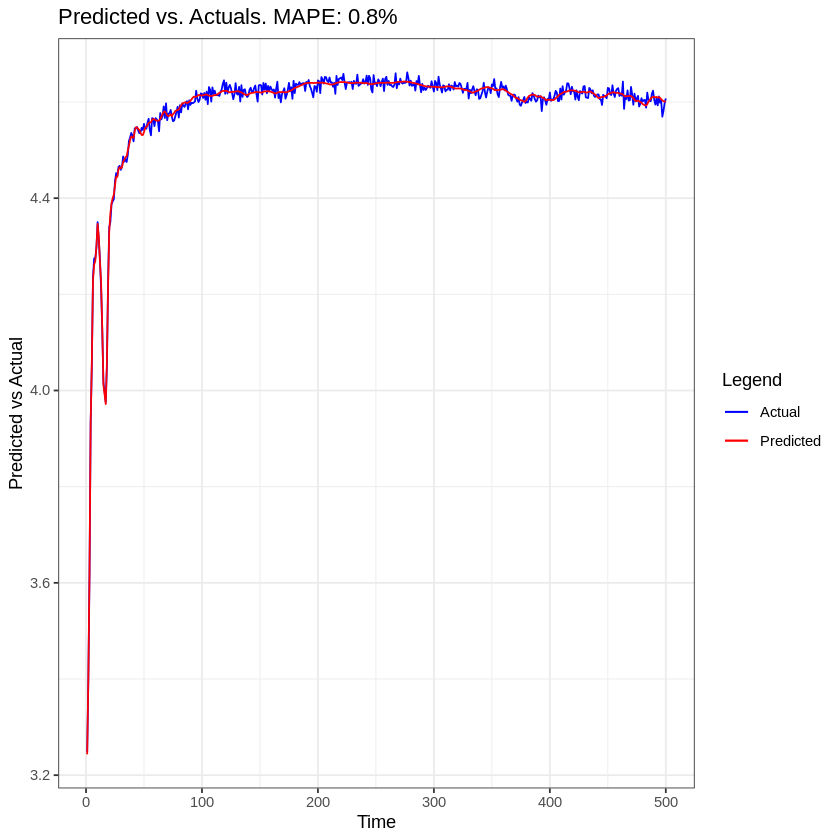

In [6]:
ef <- extract(fit)
mean_pred <- apply(ef$predicted, 2,mean)

res_df <- data.frame(true = dv, predicted = mean_pred)
res_df$idx <- 1:nrow(res_df)

mape <- mean(abs(res_df$true - res_df$predicted))

ggplot(data=res_df, aes(x=idx)) +
  ggtitle(paste("Predicted vs. Actuals. MAPE:",scales::percent(mape,0.1))) +
  geom_line(aes(y=true, color="Actual")) +
  geom_line(aes(y=predicted, color="Predicted")) +
  # expand_limits(y = 0) +
  labs(x = "Time", y = "Predicted vs Actual", color = "Legend") +
  scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red")) +
  theme_bw()